### niiha_oh_determine.py

In [1]:
#!/usr/bin/env python

import numpy as np
from scipy.interpolate import interp1d

def niiha_oh_determine(x0, type, O3N2=None, lNIISII=None, index=None, silent=None, 
                       linear=None, logLHb=None, deltsSFR=None):
    '''
    PURPOSE:
       This code estimates 12+log(O/H) based on strong-line diagnostics. It uses
       emission-line that use [NII]6583, such as [NII]6583/Halpha, [NII]/[SII].
       Also include option of using the O3N2 index

    CALLING SEQUENCE:
       niiha_oh_determine(x0, type, O3N2=O3N2, lNIISII=lNIISII, index=index,
                          silent=1, logLHb=logLHb)

    INPUTS:
       x0   -- Array of log([NII]6583/Halpha)
       type -- The type of diagnostics to use. The options are:
         'D16'        -- Dopita et al. (2016), Ap&SS, 361, 61
         'D02'        -- Denicolo (2002)
         'PP04_N2'    -- N2 index calibration of Pettini & Pagel (2004), MNRAS, 348, 59
           - Specify linear keyword to use linear instead of 3rd-order function
         'PP04_O3N2'  -- O3N2 index calibration of Pettini & Pagel (2004), MNRAS, 348, 59
         'C16'        -- Cowie et al. (2016), ApJ, 817, 57
         'BMA16_N2'   -- Eq. 7 in Brown, Martini & Andrews (2016), MNRAS, 1529, 47
         'BMA16_O3N2' -- Eq. 8 in Brown, Martini & Andrews (2016), MNRAS, 1529, 47
         'M13_N2'     -- Eq. 4 in Marino et al. (2013), AnA, 559, A114
         'M13_O3N2'   -- Eq. 2 in Marino et al. (2013), AnA, 559, A114

    OPTIONAL KEYWORD INPUT:
       O3N2    -- log(([OIII]5007/Hb)/([NII]6583/Ha))
        - Required for type = 'PP04_O3N2'
       lNIISII -- log([NII]6583/[SII]6717,6731)
        - Required for 
       index   -- Index of array to determine metallicity
       silent  -- If set, this means that nothing will be printed out
       logLHb  -- logarithm of the observed H-beta luminosity
       deltsSFR -- logarithm of Delta(sSFR). See BMA16 for definition
    '''

    if index is None: index = range(len(x0))

    ## Default sets those without metallicity at -1.0
    OH_gas = np.repeat(-1.000, len(x0))


    ######################################
    ## Empirical, PP04                  ##
    ## ---------------------------------##
    ## See Pettini & Pagel (2004)       ##
    ## Eq. A10 of Kewley & Ellison 2008 ##
    ## + on 04/03/2016                  ##
    ## Mod on 14/06/2016                ##
    ######################################
    if type == 'PP04_N2':
        if linear == None:
            OH_gas[index] = 9.37 + 2.03*x0[index] + 1.26*(x0[index])**2 + 0.32*(x0[index])**3
        else:
            print '## Using linear relation!'
            # Bug found. Mod on 30/06/2016 OH_gas -> OH_gas[index]
            OH_gas[index] = 8.90 + 0.57 * x0[index] #xt0
    #endif

    if type == 'PP04_O3N2':
        if O3N2 == None:
            print '### Need to provide O3N2 array'
            print '### Exiting!!!'
            return
        else:
            OH_gas[index] = 8.73 - 0.32 * O3N2[index]
    #endif


    return OH_gas
#enddef

In [2]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import ascii as asc, fits as pyfits

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

%matplotlib inline

In [3]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                    Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (stlr_mass >= CUTOFF_MASS))[0]

# ha_ii = np.array(corr_tbl['ID'])-1
# nbia_errs = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fix.errors.fits')
# nbia_errs_data = nbia_errs[1].data[ha_ii]

In [4]:
# this is NIIλλ6548,6583/Ha = (1+2.96)/2.96 * NIIλ6583/Ha
NIIAB_Ha = corr_tbl['NII_Ha_ratio'].data

NII6583_Ha = NIIAB_Ha * 2.96/(1+2.96)
logOH = niiha_oh_determine(NII6583_Ha, 'PP04_N2') - 12   # since this code estimates log(O/H)+12

# Ly2016
y = logOH + 3.31 
log_SFR_LHa = -41.34 + 0.39*y + 0.127*y**2

In [5]:
obs_log_LHa = corr_tbl['obs_lumin'].data
log_SFR = log_SFR_LHa + obs_log_LHa
min(log_SFR), max(log_SFR)

(-3.0969328524775364, 1.6273529147319579)

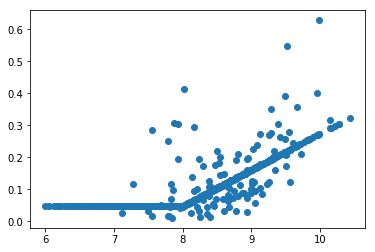

In [18]:
plt.plot(stlr_mass[good_sig_iis], NII6583_Ha[good_sig_iis], 'o')

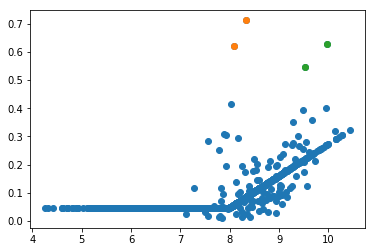

In [30]:
plt.plot(stlr_mass, NII6583_Ha, 'o')
xx = np.where((NII6583_Ha > 0.54) & (stlr_mass < 9))[0]
plt.plot(stlr_mass[xx], NII6583_Ha[xx], 'o')
yy = np.where((NII6583_Ha > 0.54) & (stlr_mass > 9))[0]
plt.plot(stlr_mass[yy], NII6583_Ha[yy], 'o')

In [34]:
maybe_agn = np.where(NII6583_Ha[good_sig_iis] > 0.54)[0]
corr_tbl[good_sig_iis][maybe_agn]

ID,NAME0,filt,inst_str0,zspec0,stlr_mass,flux_sigma,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor,EBV_errs,NBIA_errs,meas_errs
int64,str51,str5,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64
6996,Ha-NB973_064347,NB973,"merged,",0.4777,9.52,21.3098534948,-15.9199666977,41.0149472578,-0.342698155988,0.0282222349783,-0.23887312698,0.733297565299,ratio,1.01782949537,0.40150833708,0.407131798147,0.012848406817,0.0629250411364,0.0642233786075
7170,Ha-NB973_084633,NB973,"merged,",0.4909,9.98,28.2000730443,-15.7982969284,41.1649593373,-0.192686076537,0.045917276345,-0.264988270405,0.840722285852,ratio,0.740886179248,0.292261109695,0.296354471699,0.0238091575146,0.0474539720295,0.0530919527134


In [32]:
corr_tbl[xx]

ID,NAME0,filt,inst_str0,zspec0,stlr_mass,flux_sigma,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor,EBV_errs,NBIA_errs,meas_errs
int64,str51,str5,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64
5241,Ha-NB921_063859,NB921,"Keck,",0.4007,8.08,3.96065100115,-17.1141338348,39.6393553122,-1.71829010158,0.000222366019839,-0.262693388839,0.831021268059,ratio,0.755937683123,0.298198552379,0.302375073249,0.0326814855976,0.310611379718,0.312325965477
6889,Ha-NB973_054540,NB973,"Keck,",0.4793,8.32,3.51563599994,-16.7025432587,40.2358446495,-1.12180076429,0.0103531119218,-0.290741311967,0.953175697747,ratio,0.0,0.0,0.0,0.112188718805,0.386842834291,0.40278243143


Text(0,0.5,'nii6583/ha')

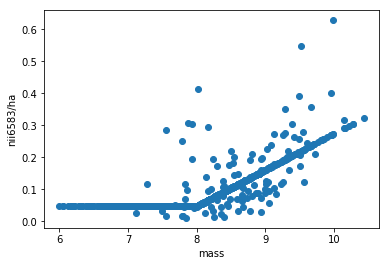

In [39]:
plt.plot(stlr_mass[good_sig_iis], NII6583_Ha[good_sig_iis], 'o')
plt.xlabel('mass')
plt.ylabel('nii6583/ha')

Text(0,0.5,'y')

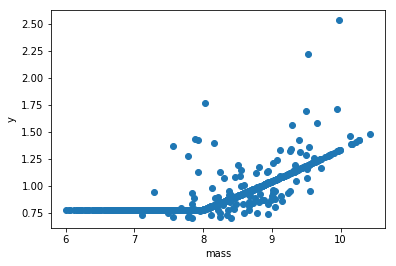

In [40]:
plt.plot(smass0, y[good_sig_iis], 'o')
plt.xlabel('mass')
plt.ylabel('y')

## rerunning the analysis with this sample

In [11]:
# assuming sfr = a*m + b*z + c
eqn0 = r'$log[SFR] = a*log[M] + b*z + c$'
def func0(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

smass0 = np.array(corr_tbl['stlr_mass'])[good_sig_iis]

zspec0 = np.array(corr_tbl['zspec0'])[good_sig_iis]
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

badz_iis = np.array([x for x in range(len(zspec0)) if zspec0[x] < 0 or zspec0[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}
ffs = filts[good_sig_iis]
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zspec0[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1

data00 = np.vstack([smass0, zspec0]).T

sfrs00 = log_SFR[good_sig_iis]

In [12]:
from scipy.optimize import curve_fit

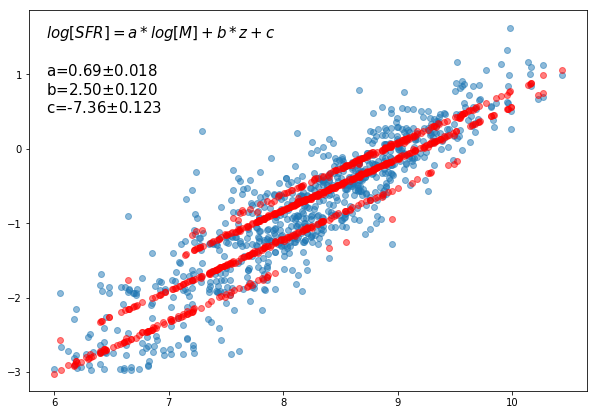

In [14]:
f, ax = plt.subplots()
params, pcov = curve_fit(func0, data00, sfrs00, method='lm')
perr = np.sqrt(np.diag(pcov))
ax.plot(smass0, sfrs00, 'o', alpha=0.5)
ax.plot(smass0, func0(data00, *params), 'ro', alpha=0.5)
ax.text(0.03,0.97,eqn0+
         '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
         '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
         '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
         transform=ax.transAxes,fontsize=15,ha='left',va='top')

f.set_size_inches(10,7)

In [16]:
sfrs_resid = sfrs00 - func0(data00, *params)

mbins0 = np.arange(6.25, 10.75, .5)
bin_ii = np.digitize(smass0, mbins0)

intr = []
for i in range(len(mbins0)):
    bin_match = np.where(bin_ii == i)[0]
    print 'mass range:', mbins0[i]-0.25, '--', mbins0[i]+0.25
    
    plot_dispersion = np.std(sfrs_resid[bin_match])
    print 'observed_sigma =',str(np.round(plot_dispersion,4)) #'plot_sigma'
    
    meas_dispersion = np.mean(corr_tbl[good_sig_iis]['meas_errs'][bin_match].data)
    print 'systematic_sigma =',str(np.round(meas_dispersion, 4)) #'measured_sigma'
    
    intr_dispersion = np.sqrt(plot_dispersion**2 - meas_dispersion**2)
    intr.append(intr_dispersion)
    print 'intrinsic_sigma =',str(np.round(intr_dispersion, 4)), '\n'

mass range: 6.0 -- 6.5
observed_sigma = 0.2785
systematic_sigma = 0.2719
intrinsic_sigma = 0.0605 

mass range: 6.5 -- 7.0
observed_sigma = 0.3009
systematic_sigma = 0.2525
intrinsic_sigma = 0.1637 

mass range: 7.0 -- 7.5
observed_sigma = 0.3602
systematic_sigma = 0.2004
intrinsic_sigma = 0.2993 

mass range: 7.5 -- 8.0
observed_sigma = 0.3583
systematic_sigma = 0.1969
intrinsic_sigma = 0.2993 

mass range: 8.0 -- 8.5
observed_sigma = 0.2934
systematic_sigma = 0.1793
intrinsic_sigma = 0.2322 

mass range: 8.5 -- 9.0
observed_sigma = 0.308
systematic_sigma = 0.1273
intrinsic_sigma = 0.2805 

mass range: 9.0 -- 9.5
observed_sigma = 0.3015
systematic_sigma = 0.0736
intrinsic_sigma = 0.2923 

mass range: 9.5 -- 10.0
observed_sigma = 0.2616
systematic_sigma = 0.0372
intrinsic_sigma = 0.2589 

mass range: 10.0 -- 10.5
observed_sigma = 0.2667
systematic_sigma = 0.0279
intrinsic_sigma = 0.2653 



Text(0.5,1,'intrinsic dispersion')

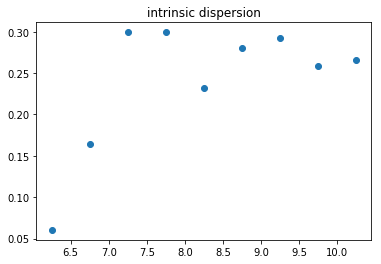

In [17]:
plt.plot(mbins0, intr, 'o', label='both')
plt.title('intrinsic dispersion')